In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bcolz
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.contrib.keras import backend as K
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import optimizers
from tensorflow.contrib.keras import applications

In [3]:
# To iterate faster, instead of loading the data
#low_arr = np.empty((10, 72, 72, 3))
#high_arr = np.empty((10, 288, 288, 3))

In [4]:
def load_array(fname):
    return bcolz.open(fname)[:]

In [5]:
low_arr = load_array('data/imgs-72x72.arr')
high_arr = load_array('data/imgs-288x288.arr')

In [6]:
low_arr.shape, high_arr.shape

((37500, 72, 72, 3), (37500, 288, 288, 3))

In [7]:
low_shape = low_arr.shape[1:]
high_shape = high_arr.shape[1:]
low_shape, high_shape

((72, 72, 3), (288, 288, 3))

Building blocks for the network

In [8]:
def conv_block(x, filters, size, stride=(2, 2), mode='same', act=True, block=0):
    name = f'sr_{block}_'
    x = layers.Convolution2D(filters, size, strides=stride, padding=mode, name=name+'conv')(x)
    x = layers.BatchNormalization(name=name+'bn')(x)
    return layers.Activation('relu', name=name+'act')(x) if act else x

In [9]:
def res_block(inp, filters=64, block=0):
    stride = (1, 1)  # Since it has the shortcut
    x = conv_block(inp, filters, 3, stride=stride, block=block)
    x = conv_block(x, filters, 3, stride=stride, act=False, block=block+1)
    return layers.Add()([x, inp])

In [10]:
def deconv_block(x, filters, size, shape, stride=(2, 2), block=0):
    name = f'sr_{block}_'
    x = layers.Conv2DTranspose(filters, size, strides=stride, padding='same', name=name+'conv')(x)
    x = layers.BatchNormalization(name=name+'bn')(x)
    return layers.Activation('relu', name=name+'act')(x)

In [11]:
def up_block(x, filters, size, block=0):
    name = f'sr_{block}_'
    x = layers.UpSampling2D(name=name+'ups')(x)
    x = layers.Convolution2D(filters, size, padding='same', name=name+'conv')(x)
    x = layers.BatchNormalization(name=name+'bn')(x)
    return layers.Activation('relu', name=name+'act')(x)

The actual super-resolution network

In [12]:
inp = layers.Input(low_shape, name='sr_inp')
x = conv_block(inp, 64, 9, stride=(1, 1), block=1)
for i in range(4):
    x = res_block(x, block=(1+i)*2)
x = up_block(x, 64, 3, block=10)
x = up_block(x, 64, 3, block=11)
x = layers.Convolution2D(3, 9, activation='tanh', padding='same', name='sr_final_conv')(x)
out = layers.Lambda(lambda x: (x + 1) * 127.5, name='sr_final_lamb')(x)

In [13]:
inp, out

(<tf.Tensor 'sr_inp:0' shape=(?, 72, 72, 3) dtype=float32>,
 <tf.Tensor 'sr_final_lamb/mul:0' shape=(?, 288, 288, 3) dtype=float32>)

Now we need a loss funcion. In this case is based on the output of a convolutional layer of VGG16 (which the paper refers to as "perceptual loss").

The loss function is going to compare the output of the same Conv Layer of 2 VGG16 models:
1. regular VGG16(input = high_res)
1. another VGG16(input = low_res with super resolution)

So both VGG have the same input shape, the high resolution shape.

We start by building a regular VGG network.

The input of both models is `vgg_inp`, the high resolution shape. For the low-res is the output of super-resolution upscaled (high-res) and for the high-res is the original images.

In [14]:
# Remove the VGG mean
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [15]:
vgg_inp_shape = high_arr.shape[1:]
vgg_inp = layers.Input(vgg_inp_shape)
vgg_inp_l = layers.Lambda(preproc)(vgg_inp)

In [16]:
# vgg = applications.VGG16(include_top=False, input_shape=vgg_inp_shape)
vgg = applications.VGG16(include_top=False, input_tensor=vgg_inp_l)
for l in vgg.layers:
    l.trainable = False

In [ ]:
# vgg.summary()

In [18]:
def get_out_layer(model, block_number):
    return model.get_layer(f'block{block_number}_conv1').output

In [19]:
get_out_layer(vgg, 1)

<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 288, 288, 64) dtype=float32>

In [20]:
vgg_content = models.Model(vgg_inp_l, get_out_layer(vgg, 1))

In [21]:
vgg_low_layer = vgg_content(out)
vgg_high_layer = vgg_content(vgg_inp)

In [22]:
vgg_low_layer, vgg_high_layer

(<tf.Tensor 'model_1/block1_conv1/Relu:0' shape=(?, 288, 288, 64) dtype=float32>,
 <tf.Tensor 'model_1/block1_conv1_1/Relu:0' shape=(?, 288, 288, 64) dtype=float32>)

Here we create two output tensors one for each of two VGG16 models. Remember that are the same model but with different inputs (both inputs have the same shape).

So that way we have 2 tensors with the same output shape

In [23]:
def mean_sqr_b(tensors): 
    dims = list(range(1, K.ndim(tensors[0])))
    return K.expand_dims(K.sqrt(K.mean((tensors[1] - tensors[0])**2, dims)), 0)

In [24]:
loss = layers.Lambda(mean_sqr_b)([vgg_high_layer, vgg_low_layer])

In [25]:
loss

<tf.Tensor 'lambda_2/ExpandDims:0' shape=(1, ?) dtype=float32>

In [26]:
m_sr = models.Model(inputs=[inp, vgg_inp], outputs=loss)

In [27]:
m_sr.compile('adam', 'mse')

The target of the model is just zeros, we want to minimize the loss we passed directly

In [28]:
target = np.zeros((high_arr.shape[0], 1))

In [29]:
m_sr.fit([low_arr, high_arr], target)

37500/37500 [==============================] - 2945s - loss: 460.1882  


This took 2945s(50m) and final loss was about: 460.1882

Now we create a model of what we actually want, input low res and output upsampled image.

In [31]:
top_model = models.Model(inp, out)

In [32]:
top_model.save('data/top_model.h5')

## Test


In [34]:
def to_plot(img):
    return np.rollaxis(img, 0, 1).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))

In [44]:
img = low_arr[322:333]

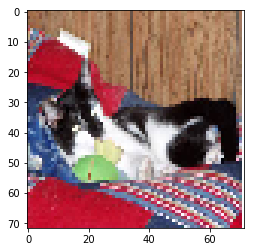

In [45]:
plot(img[0])

In [46]:
upsampled = top_model.predict(img)

In [47]:
upsampled.shape

(11, 288, 288, 3)

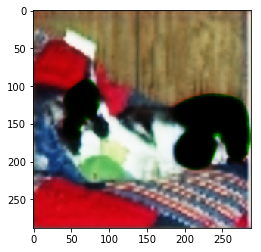

In [48]:
plot(upsampled[0])

Might not be the most impresive result ever (even tho its kinda good). Training time was very short and more epochs (and other techiques) will improve this for sure.